In [132]:
import pandas as pd
import re
import numpy as np
import random
import os
pd.set_option('display.max_columns', 500)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import sys; sys.path.insert(0, '..')

## Libraries

In [134]:
# Sklearn libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.base import TransformerMixin  # gives fit_transform method for free
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score as qwk
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    LabelBinarizer,
    MinMaxScaler,
    OneHotEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [135]:
# Regression Models
from sklearn.compose import TransformedTargetRegressor
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression
from sklearn.dummy import DummyRegressor
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    #HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    ARDRegression,
    BayesianRidge,
    ElasticNet,
    ElasticNetCV,
    GammaRegressor,
    HuberRegressor,
    Lars,
    LarsCV,
    Lasso,
    LassoCV,
    LassoLars,
    LassoLarsCV,
    LassoLarsIC,
    LinearRegression,
    MultiTaskElasticNet,
    MultiTaskElasticNetCV,
    MultiTaskLasso,
    MultiTaskLassoCV,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    PassiveAggressiveRegressor,
    PoissonRegressor,
    RANSACRegressor,
    Ridge,
    RidgeCV,
    SGDRegressor,
    TheilSenRegressor,
)
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

## Data Loading and Options

In [136]:
DATA_DIR = '../data'
MODELS_DIR = '../models'
# INPUT
EYE_DATASET = '{}/{}'.format(DATA_DIR, 'eye_dataset_clean.ftr')
# OUTPUT
MODEL = '{}/{}'.format(MODELS_DIR, 'regressor_model.pkl')
# OPTIONS
meds = True
# Macular edema or DR
target = 'dr_grade'
seed=42

In [137]:
# Read data
df = pd.read_feather(EYE_DATASET)

FileNotFoundError: [Errno 2] No such file or directory: '../data/eye_dataset_clean.ftr'

In [243]:
df = pd.read_csv('probar.csv', index_col=0)

In [244]:
dataset = df.drop(columns=['change90d', 'change180d'])

In [245]:
dataset.head()

,quantile,mad,alma,wcp,kurtosis,atr,rvi,increasing,pwma,median,rsx,ebsw,log_return,er,ao,rma,sinwma,ssf,nvi,wma,trima,pvt,ad,pvr,bias,cmo,midprice,zlma,swma,true_range,dema,massi,inertia,variance,mfi,dpo,cti,chop,pdist,apo,rsi,linreg,decay,natr,vidya,stdev,tema,cfo,entropy,willr,pgo,uo,skew,psl,obv,t3,qstick,fwma,zscore,vwap,jma,efi,slope,kama,percent_return,mcgd,adosc,eom,ema,hl2,pvol,hwma,decreasing,hlc3,mom,sma,ttm_trend,midpoint,cg,cmf,roc,vhf,bop,coppock,ohlc4,vwma,hma,ui,pvi,cci,change24hs,change7d,change30d
AAPL,147.457065,2.047985,149.365914,149.241271,-0.003238,2.661859,54.109252,0.566667,149.368759,147.457065,53.847313,0.059952,-0.000444,0.306900,1.827569,148.503699,149.257401,149.266979,1160.464804,149.307450,149.347364,3.855126e+11,4.325763e+10,2.500000,0.006781,10.362859,149.207736,149.279083,149.349687,2.823548,149.540524,25.209511,53.999860,7.047126,58.752471,0.942836,0.143545,49.748227,4.753398,1.046146,55.181429,149.434967,149.922078,1.824658,144.654485,2.586690,149.262317,-0.013305,3.326296,-46.669704,0.060169,49.839592,0.428123,53.888889,1.620748e+11,149.658604,-0.157079,149.269590,0.651199,149.246957,149.056441,-1.160407e+07,-0.065571,148.658873,-0.000359,-0.006010,-7.569340e+06,0.134021,149.144239,149.258329,1.186530e+10,148.122582,0.433333,149.246957,0.109380,149.325804,0.000000,149.256998,-5.500695,0.008465,0.137525,0.269582,-0.027375,2.037306,149.291198,149.315100,149.240313,2.424619,1994.128056,31.762850,0.003508,0.018423,0.044293
X,26.294463,1.473890,26.874826,25.930396,-0.460041,1.330451,48.948838,0.400000,26.696443,26.294463,45.580176,-0.598062,-0.008362,0.337440,0.493361,26.334444,26.741693,26.158801,851.136609,26.395760,26.679894,4.765345e+09,-1.234769e+09,2.733333,-0.018111,-3.666746,26.119286,26.051575,26.638642,1.326808,26.267214,25.221896,51.524196,3.546921,48.955049,0.562456,-0.406227,50.741762,2.179519,0.272844,48.166627,26.277389,26.172328,5.216098,25.799512,1.830917,25.970167,-0.562424,3.305777,-70.541875,-0.613271,42.087376,-0.174171,46.388889,2.691764e+08,26.946209,-0.122266,26.152093,-0.348485,25.957040,26.185368,-2.766675e+06,-0.207272,26.648551,-0.007842,25.764230,-1.157781e+07,-0.237303,26.398043,26.010327,5.393867e+08,26.931333,0.566667,25.957040,-1.091570,26.574053,-0.666667,25.954101,-5.539885,-0.064706,-3.944029,0.346044,-0.184668,0.216492,25.981881,26.584120,26.041196,7.039526,1615.137497,-71.973179,0.003417,0.118335,0.220609
KO,56.144503,0.474638,56.002846,55.575044,0.265792,0.606433,54.861937,0.466667,55.887127,56.144503,43.670420,-0.315445,-0.001526,0.213941,-0.231406,55.879810,55.951401,55.668636,1195.323104,55.772037,55.895556,9.295742e+09,6.421372e+09,2.500000,-0.009046,-5.650133,55.627723,55.618983,55.872399,0.644710,55.664148,24.929203,57.459843,0.411433,43.471886,0.185428,-0.252327,55.925022,1.059278,-0.164574,47.174933,55.685105,55.676411,1.100116,55.446747,0.613365,55.566064,-0.067716,3.315669,-65.057853,-0.614401,46.749154,-0.657346,54.444444,6.537639e+09,55.975344,-0.048548,55.672872,-0.885419,55.581492,55.632992,-1.460710e+06,-0.084141,55.897748,-0.001496,55.844695,-4.897002e+06,-0.302384,55.815336,55.594388,7.491850e+08,55.524031,0.533333,55.581492,-0.522071,55.855402,-0.266667,55.597771,-5.508286,-0.086466,-0.928799,0.265845,-0.104225,-1.540598,55.593453,55.813903,55.611858,1.760436,1668.796763,-59.522858,0.013010,0.015544,0.052593
PBR,10.429608,0.281691,10.467650,10.362757,-0.347102,0.386016,45.462674,0.466667,10.436727,10.429608,49.297142,-0.112823,-0.001060,0.258280,0.006386,10.419882,10.447456,10.376078,1230.613331,10.405337,10.437680,-1.262275e+09,1.058849e+09,2.500000,-0.004606,-1.802155,10.371275,10.365016,10.432048,0.382534,10.386169,24.970559,44.986498,0.120942,46.003300,0.055506,-0.092496,47.278939,0.633425,0.024768,49.098923,10.385421,10.392247,3.735402,10.350900,0.345097,10.362018,0.008388,3.315118,-46.838660,-0.217540,50.138256,-0.216852,45.833333,2.536311e+09,10.457667,0.006031,10.380726,-0.041658,10.363926,10.373806,-1.105016e+05,-0.011096,10.30774

## Data Preprocessing

In [246]:
# Drop unnecessary columns
df.drop(
    columns=[
        "diabetes_type",
        #dr_grade",
        "me",
        "recent_blood_test",
        "pupil_dilation",
        "last_eye_exam",
    ],
    inplace=True,
)

KeyError: "['diabetes_type' 'me' 'recent_blood_test' 'pupil_dilation' 'last_eye_exam'] not found in axis"

In [247]:
# Drop medicaments columns if meds=False
if not meds:
    no_meds_cols = [col for col in df.columns if not col.startswith('med')]
    df = df[no_meds_cols]

In [248]:
df.head()

,quantile,mad,alma,wcp,kurtosis,atr,rvi,increasing,pwma,median,rsx,ebsw,log_return,er,ao,rma,sinwma,ssf,nvi,wma,trima,pvt,ad,pvr,bias,cmo,midprice,zlma,swma,true_range,dema,massi,inertia,variance,mfi,dpo,cti,chop,pdist,apo,rsi,linreg,decay,natr,vidya,stdev,tema,cfo,entropy,willr,pgo,uo,skew,psl,obv,t3,qstick,fwma,zscore,vwap,jma,efi,slope,kama,percent_return,mcgd,adosc,eom,ema,hl2,pvol,hwma,decreasing,hlc3,mom,sma,ttm_trend,midpoint,cg,cmf,roc,vhf,bop,coppock,ohlc4,vwma,hma,ui,pvi,cci,change24hs,change7d,change30d,change90d,change180d
AAPL,147.457065,2.047985,149.365914,149.241271,-0.003238,2.661859,54.109252,0.566667,149.368759,147.457065,53.847313,0.059952,-0.000444,0.306900,1.827569,148.503699,149.257401,149.266979,1160.464804,149.307450,149.347364,3.855126e+11,4.325763e+10,2.500000,0.006781,10.362859,149.207736,149.279083,149.349687,2.823548,149.540524,25.209511,53.999860,7.047126,58.752471,0.942836,0.143545,49.748227,4.753398,1.046146,55.181429,149.434967,149.922078,1.824658,144.654485,2.586690,149.262317,-0.013305,3.326296,-46.669704,0.060169,49.839592,0.428123,53.888889,1.620748e+11,149.658604,-0.157079,149.269590,0.651199,149.246957,149.056441,-1.160407e+07,-0.065571,148.658873,-0.000359,-0.006010,-7.569340e+06,0.134021,149.144239,149.258329,1.186530e+10,148.122582,0.433333,149.246957,0.109380,149.325804,0.000000,149.256998,-5.500695,0.008465,0.137525,0.269582,-0.027375,2.037306,149.291198,149.315100,149.240313,2.424619,1994.128056,31.762850,0.003508,0.018423,0.044293,0.118746,0.192081
X,26.294463,1.473890,26.874826,25.930396,-0.460041,1.330451,48.948838,0.400000,26.696443,26.294463,45.580176,-0.598062,-0.008362,0.337440,0.493361,26.334444,26.741693,26.158801,851.136609,26.395760,26.679894,4.765345e+09,-1.234769e+09,2.733333,-0.018111,-3.666746,26.119286,26.051575,26.638642,1.326808,26.267214,25.221896,51.524196,3.546921,48.955049,0.562456,-0.406227,50.741762,2.179519,0.272844,48.166627,26.277389,26.172328,5.216098,25.799512,1.830917,25.970167,-0.562424,3.305777,-70.541875,-0.613271,42.087376,-0.174171,46.388889,2.691764e+08,26.946209,-0.122266,26.152093,-0.348485,25.957040,26.185368,-2.766675e+06,-0.207272,26.648551,-0.007842,25.764230,-1.157781e+07,-0.237303,26.398043,26.010327,5.393867e+08,26.931333,0.566667,25.957040,-1.091570,26.574053,-0.666667,25.954101,-5.539885,-0.064706,-3.944029,0.346044,-0.184668,0.216492,25.981881,26.584120,26.041196,7.039526,1615.137497,-71.973179,0.003417,0.118335,0.220609,0.137942,0.477554
KO,56.144503,0.474638,56.002846,55.575044,0.265792,0.606433,54.861937,0.466667,55.887127,56.144503,43.670420,-0.315445,-0.001526,0.213941,-0.231406,55.879810,55.951401,55.668636,1195.323104,55.772037,55.895556,9.295742e+09,6.421372e+09,2.500000,-0.009046,-5.650133,55.627723,55.618983,55.872399,0.644710,55.664148,24.929203,57.459843,0.411433,43.471886,0.185428,-0.252327,55.925022,1.059278,-0.164574,47.174933,55.685105,55.676411,1.100116,55.446747,0.613365,55.566064,-0.067716,3.315669,-65.057853,-0.614401,46.749154,-0.657346,54.444444,6.537639e+09,55.975344,-0.048548,55.672872,-0.885419,55.581492,55.632992,-1.460710e+06,-0.084141,55.897748,-0.001496,55.844695,-4.897002e+06,-0.302384,55.815336,55.594388,7.491850e+08,55.524031,0.533333,55.581492,-0.522071,55.855402,-0.266667,55.597771,-5.508286,-0.086466,-0.928799,0.265845,-0.104225,-1.540598,55.593453,55.813903,55.611858,1.760436,1668.796763,-59.522858,0.013010,0.015544,0.052593,0.064479,0.167117
PBR,10.429608,0.281691,10.467650,10.362757,-0.347102,0.386016,45.462674,0.466667,10.436727,10.429608,49.297142,-0.112823,-0.001060,0.258280,0.006386,10.419882,10.447456,10.376078,1230.613331,10.405337,10.437680,-1.262275e+09,1.058849e+09,2.500000,-0.004606,-1.802155,10.371275,10.365016,10.432048,0.382534,10.386169,24.970559,44.986498,0.120942,46.003300,0.055506,-0.092496,47.278939,0.633425,0.024768,49.098923,10.385421,10.392247,3.735402,10.350900,0.345097,10.362018,0.008388,3.315118,-46.838660,-0.217540,50.138256,-0.216852,45.833333,2.536311e+09,10.457667,0.0060

In [249]:
df[target] = df[target].astype(str)

KeyError: 'dr_grade'

In [250]:
y_orig = pd.concat([dataset.pop(x) for x in ['change24hs', 'change7d', 'change30d']], axis=1)
X_orig = dataset

## Pipeline Building

In [266]:
numeric_features = list(dataset.select_dtypes('number').columns)
bool_features = list(dataset.select_dtypes('bool').columns)
categorical_features = list(dataset.select_dtypes(include='object').columns)

from sklearn.utils import all_estimators
from sklearn import base

estimators = all_estimators()

my_list = []

for name, class_ in estimators:
    if issubclass(class_, base.RegressorMixin):
        my_list.append(str(class_))
        print(class_)

for item in my_list:
    splits = item.split('.')
    try:
        print('from sklearn.'+splits[1]+' import '+splits[3].replace("'>",''))
    except:
        print(splits)

In [267]:
# For support new version of sklearn
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [268]:
# Types transformers
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
bool_transformer = Pipeline(steps=[("label_binarizer", MyLabelBinarizer())])
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [269]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bool", bool_transformer, bool_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [270]:
preprocessor.fit(dataset)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['quantile', 'mad', 'alma', 'wcp', 'kurtosis',
                                  'atr', 'rvi', 'increasing', 'pwma', 'median',
                                  'rsx', 'ebsw', 'log_return', 'er', 'ao',
                                  'rma', 'sinwma', 'ssf', 'nvi', 'wma', 'trima',
                                  'pvt', 'ad', 'pvr', 'bias', 'cmo', 'midprice',
                                  'zlma', 'swma', 'true_range', ...]),
                                ('bool',
                                 Pipeline(steps=[('label_binarizer',
                                                  <__main__.MyLabelBinarizer object at 0x7f15a08e9340>)]),
                                 []),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  Simpl

get_model= lambda x: re.search(r'(\w*)', x).group(1) + '()'

for we in [get_model(model) for model in text.split('-')]:
    print(we+',')

## Train/test stratified

In [271]:
scaler = StandardScaler()

X = X_orig
y = y_orig#scaler.fit_transform(np.array(y_orig).astype(int).reshape(-1,1))#.ravel()

In [272]:
seed = 42

In [273]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Select best regressors

In [274]:
regressors = [
    ARDRegression(),
    AdaBoostRegressor(),
    BaggingRegressor(),
    BayesianRidge(),
    CCA(),
    DecisionTreeRegressor(),
    DummyRegressor(),
    ElasticNet(),
    ElasticNetCV(),
    ExtraTreeRegressor(),
    ExtraTreesRegressor(),
    GammaRegressor(),
    GaussianProcessRegressor(),
    GradientBoostingRegressor(),
    HuberRegressor(),
    IsotonicRegression(),
    KNeighborsRegressor(),
    KernelRidge(),
    Lars(),
    LarsCV(),
    Lasso(),
    LassoCV(),
    LassoLars(),
    LassoLarsCV(),
    LassoLarsIC(),
    LinearRegression(),
    LinearSVR(),
    MLPRegressor(),
    MultiTaskElasticNet(),
    MultiTaskElasticNetCV(),
    MultiTaskLasso(),
    MultiTaskLassoCV(),
    NuSVR(),
    OrthogonalMatchingPursuit(),
    OrthogonalMatchingPursuitCV(),
    PLSCanonical(),
    PLSRegression(),
    PassiveAggressiveRegressor(),
    PoissonRegressor(),
    RANSACRegressor(),
    RadiusNeighborsRegressor(),
    RandomForestRegressor(),
    Ridge(),
    RidgeCV(),
    SGDRegressor(),
    SVR(),
    TheilSenRegressor(),
    TransformedTargetRegressor(),
]

In [275]:
my_list = []

for regressor in regressors:
    clf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", regressor),
        ]
    )

    model_name = type(regressor).__name__
    try:
        clf.fit(X_orig, y_orig)
        score = clf.score(X_orig, y_orig)
        my_list.append({"model": model_name, "score": score})
        print(f"{model_name} score: %.3f" % score)
    except:
        print(model_name)

ARDRegression
AdaBoostRegressor
BaggingRegressor score: 0.800
BayesianRidge
CCA score: 0.075
DecisionTreeRegressor score: 1.000
DummyRegressor score: 0.000
ElasticNet score: 0.000
ElasticNetCV
ExtraTreeRegressor score: 1.000
ExtraTreesRegressor score: 1.000
GammaRegressor
GaussianProcessRegressor score: 1.000
GradientBoostingRegressor
HuberRegressor
IsotonicRegression
KNeighborsRegressor score: 0.260
KernelRidge score: 0.752
Lars score: -784480013118849964488517552919879352320.000
LarsCV
Lasso score: 0.000
LassoCV
LassoLars score: 0.000
LassoLarsCV
LassoLarsIC
LinearRegression score: 1.000
LinearSVR
MLPRegressor score: -0.190
MultiTaskElasticNet score: 0.000


/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=4.317e-02, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=2.859e-02, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.364789148041952e-05, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011326509760174741, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013172894215131292, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001384496057389533, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013210073392506752, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012581448048062972, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pac

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006915148895389606, tolerance: 7.501103990632156e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009748962369691069, tolerance: 7.501103990632156e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011224342022080752, tolerance: 7.501103990632156e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pa

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.81008077845452e-05, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012928103813369257, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016251023146507393, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pack

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009903777221198116, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009818377153931984, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009639890294221094, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packa

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016970744402346016, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017322134739569499, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017530680844390434, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pa

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006460565120845604, tolerance: 8.247176338814209e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006243553293830547, tolerance: 8.247176338814209e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006013437453794672, tolerance: 8.247176338814209e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pa

MultiTaskElasticNetCV score: 0.315
MultiTaskLasso score: 0.000


/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003301602061747816, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003313083829918767, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003791766897203036, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pa

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012288114182696938, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011478872151033412, tolerance: 7.034162012923969e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019266313132262902, tolerance: 7.501103990632156e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-p

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009706236989397883, tolerance: 7.501103990632156e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.84407228505385e-05, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.927426969943363e-05, tolerance: 6.93371882733615e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packa

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.880701061199451e-05, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.675038690612868e-05, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012008335030291167, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-p

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001821372936461457, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018576213000912264, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018878844822390085, tolerance: 6.695823731291786e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pac

/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008978174694516013, tolerance: 8.247176338814209e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008648393118378256, tolerance: 8.247176338814209e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007805143519588756, tolerance: 8.247176338814209e-05
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/gerac/.local/lib/python3.9/site-pa

MultiTaskLassoCV score: 0.317
NuSVR
OrthogonalMatchingPursuit score: 0.511
OrthogonalMatchingPursuitCV
PLSCanonical score: -14.358
PLSRegression score: 0.157
PassiveAggressiveRegressor
PoissonRegressor
RANSACRegressor
RadiusNeighborsRegressor score: 1.000
RandomForestRegressor score: 0.863
Ridge score: 0.819
RidgeCV score: 0.621
SGDRegressor
SVR
TheilSenRegressor
TransformedTargetRegressor score: 1.000


In [276]:
pd.DataFrame(my_list).sort_values(by='score', ascending=False)

,model,score
13,LinearRegression,1.000000e+00
5,ExtraTreeRegressor,1.000000e+00
22,RadiusNeighborsRegressor,1.000000e+00
7,GaussianProcessRegressor,1.000000e+00
6,ExtraTreesRegressor,1.000000e+00
26,TransformedTargetRegressor,1.000000e+00
2,DecisionTreeRegressor,1.000000e+00
23,RandomForestRegressor,8.631982e-01
24,Ridge,8.190621e-01
0,BaggingRegressor,7.998747e-01


## Best regressor - Stratified KFold

In [22]:
# regressor = GradientBoostingRegressor(n_estimators=200)
# regressor = NuSVR()
# Import SKORCH NN classifier
from src import NeuralNet
from skorch import NeuralNetClassifier

# The Neural Net is initialized with fixed hyperparameters
regressor = NeuralNetClassifier(NeuralNet, max_epochs=10, lr=0.01, batch_size=12, optimizer=optim.RMSprop)


clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", regressor),
    ]
)

model_name = type(regressor).__name__
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

X = np.array(X_orig)
y = np.array(y_orig).reshape(-1,1)

for train_ix, test_ix in skf.split(X_orig, y_orig):
    print('amount of samples: {}'.format(len(train_ix)))
    # select rows
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    
    # TODO: do this more pythonic
    train_y, test_y = scaler.transform(train_y), scaler.transform(test_y)
    clf.fit(X_train, y_train)
    print(f"{model_name} score: %.5f" % clf.score(X_test, y_test))

ImportError: cannot import name 'NeuralNet' from 'src' (unknown location)

In [277]:
regressor = RandomForestRegressor()

clf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", regressor),
        ]
    )

model_name = type(regressor).__name__

try:
    clf.fit(X_orig, y_orig)
    score = clf.score(X_orig, y_orig)
    my_list.append({"model": model_name, "score": score})
    print(f"{model_name} score: %.3f" % score)
except:
    print(model_name)

RandomForestRegressor score: 0.857


## Feature importances

In [281]:
feature_importance = pd.DataFrame(regressor.feature_importances_, all_features).rename(columns={0:'importance'})

In [282]:
feature_importance.sort_values(by='importance', ascending=False)

,importance
pvi,0.081879
cfo,0.058543
dpo,0.049153
pvol,0.030534
cti,0.029003
...,...
hma,0.000973
ohlc4,0.000955
alma,0.000939
zlma,0.000863


In [206]:
feature_importance = (
        pd.DataFrame(regressor.coef_)
    )

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [207]:
feature_importance.mean().sort_values(ascending=False).head(10)

importance    0.011111
dtype: float64

In [280]:
if model_name == "RandomForestRegressor":
#     clf["model"].feature_importances_
    regressor.feature_importances_

#     ohe_categories = (
#         preprocessor.fit(X_train).named_transformers_["cat"]["onehot"].categories_
#     )
    ohe_categories_concat = [
        f"{col}__{val}"
        for col, vals in zip(categorical_features, ohe_categories)
        for val in vals
    ]
    all_features = numeric_features + bool_features + ohe_categories_concat
    importance = clf.named_steps["regressor"].feature_importances_
#     feature_importance = (
#         pd.DataFrame(importance, index=all_features)
#         .rename(columns={0: "pct_importance"})
#         .sort_values(by="pct_importance", ascending=False)
#     )
#     features_imp = (feature_importance[feature_importance.pct_importance > 0.005])

In [283]:
test_dataset = pd.read_csv('cedears_dataset.csv', index_col=0)

In [284]:
test_dataset.columns

Index(['quantile', 'mad', 'alma', 'wcp', 'kurtosis', 'atr', 'rvi',
       'increasing', 'pwma', 'median', 'rsx', 'ebsw', 'log_return', 'er', 'ao',
       'rma', 'sinwma', 'ssf', 'nvi', 'wma', 'trima', 'pvt', 'ad', 'pvr',
       'bias', 'cmo', 'midprice', 'zlma', 'swma', 'true_range', 'dema',
       'massi', 'inertia', 'variance', 'mfi', 'dpo', 'cti', 'chop', 'pdist',
       'apo', 'rsi', 'linreg', 'decay', 'natr', 'vidya', 'stdev', 'tema',
       'cfo', 'entropy', 'willr', 'pgo', 'uo', 'skew', 'psl', 'obv', 't3',
       'qstick', 'fwma', 'zscore', 'vwap', 'jma', 'efi', 'slope', 'kama',
       'percent_return', 'mcgd', 'adosc', 'eom', 'ema', 'hl2', 'pvol', 'hwma',
       'decreasing', 'hlc3', 'mom', 'sma', 'ttm_trend', 'midpoint', 'cg',
       'cmf', 'roc', 'vhf', 'bop', 'coppock', 'ohlc4', 'vwma', 'hma', 'ui',
       'pvi', 'cci', 'change24hs', 'change7d', 'change30d', 'change90d',
       'change180d'],
      dtype='object')

In [287]:
test_dataset.drop(columns=['change24hs', 'change7d', 'change30d', 'change90d', 'change180d'], inplace=True)

In [291]:
test_dataset.index

Index(['AAPL', 'X', 'KO', 'PBR', 'HMY', 'VALE', 'XOM', 'ITUB', 'HSBC', 'SQ',
       'SQ', 'SQ', 'SNOW', 'QCOM', 'INTC', 'DESP', 'BBD', 'HAL', 'T', 'CVX',
       'WFC', 'SPOT', 'GPRK', 'BIDU', 'SHOP', 'AUY', 'PAAS', 'MA', 'ZM', 'BB',
       'PTR', 'ETSY', 'ARCO', 'CSCO', 'UGP', 'MO', 'CX', 'AVGO', 'HOG', 'PSX',
       'BRFS', 'ABBV', 'DOCU', 'SAN', 'BP', 'ABEV', 'WBA', 'SLB', 'ERIC',
       'GFI', 'HL'],
      dtype='object')

In [298]:
pd.DataFrame(clf.predict(test_dataset), test_dataset.index).rename(
    columns={0: "change24hs", 1: "change7d", 2: "change30d"}
).sort_values(by="change7d", ascending=False)

,change24hs,change7d,change30d
MA,0.001313,0.032669,0.070732
SQ,0.010313,0.030682,0.098220
SQ,0.010313,0.030682,0.098220
SQ,0.010313,0.030682,0.098220
SNOW,0.019665,0.029563,0.108671
SHOP,0.001601,0.028485,0.066503
INTC,-0.002945,0.027697,0.034514
DOCU,0.003380,0.026503,0.099633
BIDU,-0.000788,0.024954,0.097695
SPOT,0.019596,0.024726,0.120507


In [161]:
len(all_features)

90

In [66]:
for we in [item.replace('med_','') for item in list(features_imp.index) if 'med' in item]:
    print(we)

metformin
insulin glargine
lisinopril
glimepiride
vitamin
sitagliptin
aspirin


## Create DataFrame of results

In [212]:
# Get original labels values
y_test_classification = (
    np.squeeze(scaler.inverse_transform(np.array(y_test).reshape(-1, 1)))
    .astype(int)
    .tolist()
)

In [213]:
y_pred = clf.predict(X_test)

In [214]:
pd.concat(
    [
        pd.DataFrame(y_pred, columns=["y_pred"]),
        pd.DataFrame(np.array(y_test), columns=["y_test"]),
    ],
    axis=1,
)

,y_pred,y_test
0,0.391628,0.675451
1,-0.020979,-0.967580
2,-1.013586,-0.131616
3,-0.330879,1.461690
4,0.141455,-0.131616
...,...,...
2376,-0.135296,1.461690
2377,-0.129588,-0.131616
2378,0.528785,1.461690
2379,-0.106931,1.461690


## Thresholds functions

In [280]:
MAX_DIAGNOSIS = 4


def apply_thresholds(output, thrs):
    for i in range(MAX_DIAGNOSIS + 1):
        if (i == 0) and (output < thrs[0]):
            return int(0)
        elif (i < MAX_DIAGNOSIS) and (thrs[i - 1] <= output < thrs[i]):
            return int(i)
        elif i == MAX_DIAGNOSIS:
            return int(MAX_DIAGNOSIS)
    return int(-1)

In [281]:
thrs = [0.25, 0.50, 0.75, 1]

offset = 1
# Create n amount of thresholds
def tuning_thresholds(n):
    my_list = []
    arr = np.array(thrs)
    for i in range(n):
        for i, val_treshold in enumerate(thrs):
            arr[i] = random.uniform(val_treshold - offset, val_treshold + offset)
        arr = np.sort(arr)
        my_list.append(arr)
    return my_list

In [282]:
# Create threshols
my_thrs = tuning_thresholds(100_000)

In [283]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef as mcc

In [284]:
weights = np.array(
    [
        [7, 4, 3, 2, 1],
        [-4, 6, 4, 3, 2],
        [-5, -4, 5, 4, 3],
        [-6, -5, -4, 6, 4],
        [-7, -6, -5, -4, 7],
    ]
)

In [285]:
# weights = np.array(
#     [
#         [7, 5, 4, 3, 2],
#         [-4, 7, 5, 4, 3],
#         [-5, -4, 7, 5, 4],
#         [-6, -5, -40, 7, 5],
#         [-7, -6, -50, -4, 7],
#     ]
# )

In [286]:
results = []
y_preds = []

# Min qwk to save in results
#min_qwk = 0.3

# TODO: create a genetic algorithm to sustitute this brute force algorithm
for threshold in tqdm(my_thrs):
    new_threshold = np.sort(threshold)
    y_pred_classification = []
    # TODO: process this in batches instead one by one
    for pred in y_pred:
        final_value = apply_thresholds(pred, new_threshold)
        y_pred_classification.append(final_value)
    # Compute qwk
    qwk_ = qwk(y_test_classification, y_pred_classification, weights="quadratic")
#     mcc_ = mcc(y_test_classification, y_pred_classification)
    score = (confusion_matrix(y_test_classification, y_pred_classification)*weights).sum()
#     if qwk_ > min_qwk:
    results.append(
        {
            "t0": new_threshold[0],
            "t1": new_threshold[1],
            "t2": new_threshold[2],
            "t3": new_threshold[3],
            "qwk": qwk_,
#             "mcc": mcc_,
            "score": score,
            "y_pred": y_pred_classification,
        }
    )
    y_preds.append(y_pred_classification)
    
# Create results DataFrame
results_df = pd.DataFrame(results)

100%|██████████| 100000/100000 [12:41<00:00, 131.36it/s]


In [288]:
results_df.sort_values(by='qwk', ascending=False)

,t0,t1,t2,t3,qwk,score,y_pred
4863,-0.456463,-0.346585,0.147046,0.478668,0.398615,4140,"[3, 2, 0, 2, 2, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
10300,-0.494865,-0.291410,0.066230,0.471714,0.398403,4224,"[3, 2, 0, 1, 3, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
15486,-0.674689,-0.322114,0.136929,0.463716,0.397478,4481,"[3, 2, 0, 1, 3, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
38001,-0.438161,-0.347813,0.132220,0.425037,0.396747,4294,"[3, 2, 0, 2, 3, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
61488,-0.478559,-0.354850,0.154260,0.474429,0.396735,4185,"[3, 2, 0, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 3, 2, ..."
...,...,...,...,...,...,...,...
40001,1.185100,1.198045,1.693083,1.697377,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
88595,1.204782,1.210661,1.445003,1.699440,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
53182,1.170008,1.196941,1.257897,1.407421,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
72446,1.193020,1.204997,1.268980,1.342341,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [289]:
# BaggingRegressor
results_df.sort_values(by='score', ascending=False)

,t0,t1,t2,t3,qwk,score,y_pred
26028,-0.585712,-0.469302,-0.179354,0.028348,0.310162,7308,"[4, 3, 0, 2, 4, 4, 3, 3, 3, 3, 4, 4, 3, 4, 2, ..."
58270,-0.669667,-0.402987,-0.240262,0.052905,0.309595,7299,"[4, 3, 0, 2, 4, 4, 3, 3, 3, 3, 4, 4, 3, 4, 3, ..."
14799,-0.725142,-0.456604,-0.164255,0.082377,0.319315,7265,"[4, 3, 0, 2, 4, 4, 3, 3, 2, 3, 4, 4, 3, 4, 2, ..."
12225,-0.706335,-0.449515,-0.135754,0.144466,0.340266,6983,"[4, 3, 0, 2, 3, 4, 3, 3, 2, 3, 4, 4, 3, 4, 2, ..."
96640,-0.632320,-0.425254,-0.183863,0.131604,0.332095,6943,"[4, 3, 0, 2, 4, 4, 3, 3, 3, 3, 4, 4, 3, 4, 2, ..."
...,...,...,...,...,...,...,...
72293,1.231348,1.287043,1.632872,1.735750,0.000000,-10029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76723,1.247037,1.307367,1.637066,1.640925,0.000000,-10029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
81321,1.247785,1.398711,1.453995,1.555029,0.000000,-10029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
74571,1.248954,1.394309,1.688130,1.825632,0.000000,-10029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [290]:
# BaggingRegressor
results_df.sort_values(by='qwk', ascending=False)

,t0,t1,t2,t3,qwk,score,y_pred
4863,-0.456463,-0.346585,0.147046,0.478668,0.398615,4140,"[3, 2, 0, 2, 2, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
10300,-0.494865,-0.291410,0.066230,0.471714,0.398403,4224,"[3, 2, 0, 1, 3, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
15486,-0.674689,-0.322114,0.136929,0.463716,0.397478,4481,"[3, 2, 0, 1, 3, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
38001,-0.438161,-0.347813,0.132220,0.425037,0.396747,4294,"[3, 2, 0, 2, 3, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, ..."
61488,-0.478559,-0.354850,0.154260,0.474429,0.396735,4185,"[3, 2, 0, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 3, 2, ..."
...,...,...,...,...,...,...,...
40001,1.185100,1.198045,1.693083,1.697377,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
88595,1.204782,1.210661,1.445003,1.699440,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
53182,1.170008,1.196941,1.257897,1.407421,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
72446,1.193020,1.204997,1.268980,1.342341,-0.000050,-10019,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# NuSVR
results_df.sort_values(by='qwk', ascending=False)

## Retrieve the best thresholds from results

In [296]:
metric = 'qwk'
y_pred_classification = results_df.sort_values(by=metric, ascending=False).iloc[0]['y_pred']
metric_final = results_df.sort_values(by=metric, ascending=False).iloc[0][metric]
qwk_final = results_df.sort_values(by=metric, ascending=False).iloc[0]['qwk']
score_final = results_df.sort_values(by=metric, ascending=False).iloc[0]['score']

In [297]:
metric_final

0.3986150965348587

## Assert qwk

In [298]:
#qwk(y_pred_classification, y_test_classification, weights='quadratic')

## Create Classification DataFrame

In [299]:
classification_df = pd.concat(
    [
        pd.DataFrame(y_pred_classification, columns=["y_pred"]),
        pd.DataFrame(y_test_classification, columns=["y_test"]),
    ],
    axis=1,
)

## Confusion matrix

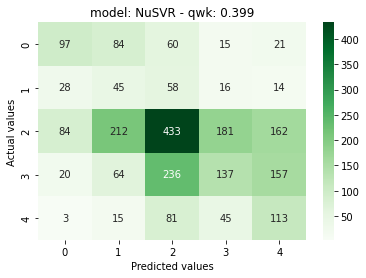

In [300]:
import seaborn as sns
# BaggingRegressor - 150000 - qwk:0.40177

confusion_matrix = pd.crosstab(
    classification_df.y_pred,
    classification_df.y_test,
    rownames=["Actual values"],
    colnames=["Predicted values"],
)

ax = plt.axes()

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt=".0f",
    cmap="Greens",
    ax=ax
)

ax.set_title('model: {} - qwk: {:.3f}'.format(model_name, qwk_final))
plt.show()

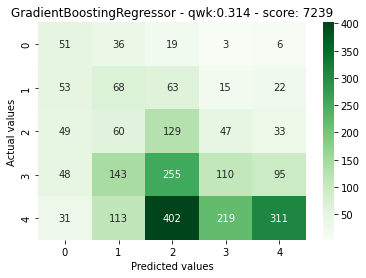

In [275]:
import seaborn as sns
# BaggingRegressor - 150000 - qwk:0.40177

confusion_matrix = pd.crosstab(
    classification_df.y_pred,
    classification_df.y_test,
    rownames=["Actual values"],
    colnames=["Predicted values"],
)

ax = plt.axes()

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt=".0f",
    cmap="Greens",
    ax=ax
)

ax.set_title('{} - qwk:{:.3f} - score: {:.0f}'.format(model_name, qwk_final,score_final))
plt.show()

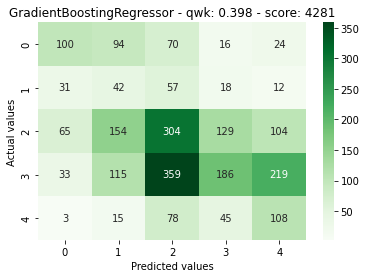

In [245]:
import seaborn as sns
# BaggingRegressor - 150000 - qwk:0.40177

confusion_matrix = pd.crosstab(
    classification_df.y_pred,
    classification_df.y_test,
    rownames=["Actual values"],
    colnames=["Predicted values"],
)

ax = plt.axes()

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt=".0f",
    cmap="Greens",
    ax=ax
)

ax.set_title('{} - {}: {:.3f} - score: {:.0f}'.format(model_name, metric, metric_final,score_final))
plt.show()

NameError: name 'qwk_final' is not defined

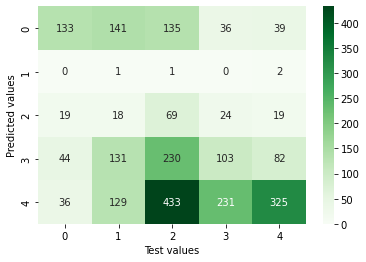

In [169]:
import seaborn as sns
# BaggingRegressor - 150000 - qwk:0.40177

confusion_matrix = pd.crosstab(
    classification_df.y_pred,
    classification_df.y_test,
    rownames=["Predicted values"],
    colnames=["Test values"],
)

ax = plt.axes()

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt=".0f",
    cmap="Greens",
    ax=ax
)

ax.set_title('model: {} - qwk: {:.3f}'.format(model_name, qwk_final))
plt.show()

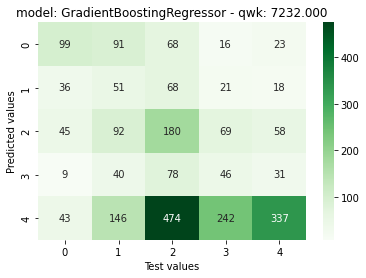

In [138]:
import seaborn as sns
# BaggingRegressor - 150000 - qwk:0.40177

confusion_matrix = pd.crosstab(
    classification_df.y_pred,
    classification_df.y_test,
    rownames=["Predicted values"],
    colnames=["Test values"],
)

ax = plt.axes()

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt=".0f",
    cmap="Greens",
    ax=ax
)

ax.set_title('model: {} - qwk: {:.3f}'.format(model_name, qwk_final))
plt.show()

<AxesSubplot:xlabel='Test values', ylabel='Predicted values'>

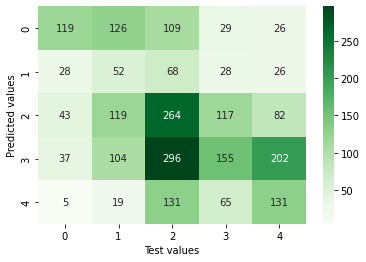

In [701]:
# BaggingRegressor

sns.heatmap(
    pd.crosstab(
        classification_df.y_pred,
        classification_df.y_test,
        rownames=["Predicted values"],
        colnames=["Test values"],
    ),
    annot=True,
    fmt=".0f",
    cmap="Greens",
)

<AxesSubplot:xlabel='Test values', ylabel='Predicted values'>

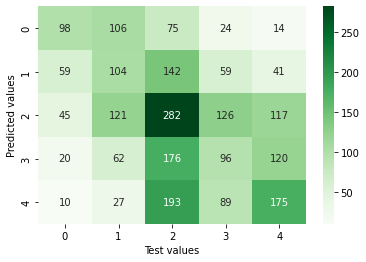

In [687]:
import seaborn as sns

# NuSVR

sns.heatmap(
    pd.crosstab(
        classification_df.y_pred,
        classification_df.y_test,
        rownames=["Predicted values"],
        colnames=["Test values"],
    ),
    annot=True,
    fmt=".0f",
    cmap="Greens",
)

In [201]:
pd.crosstab(pd.DataFrame(y_test_classification)[0], pd.DataFrame(y_pred_class)[0])

,0,1,2,3,4
0,,,,,
0,74,58,73,24,3
1,60,75,187,83,15
2,47,79,388,272,82
3,10,24,165,147,48
4,8,28,142,174,115


# Plot AUCROC

[[ 75  63  49  12  10]
 [ 57  77  80  23  27]
 [ 69 164 328 138 117]
 [ 28 104 350 189 222]
 [  3  12  61  32  91]]


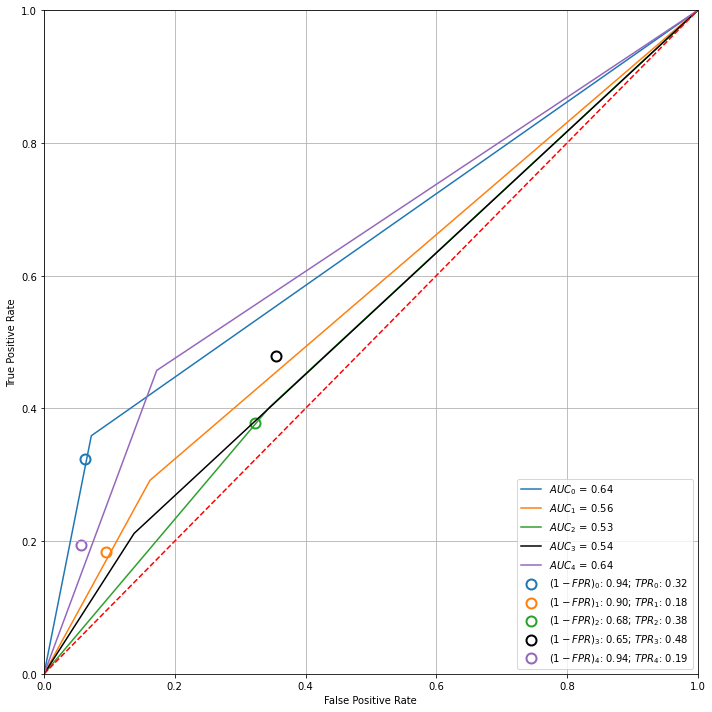

In [40]:
viz.plot_ROC(y_pred_classification, y_test_classification)

[[ 94  72  66  25  15]
 [ 42  72  84  20  30]
 [ 64 174 314 131 117]
 [ 26  70 201 112 106]
 [  6  32 203 106 199]]


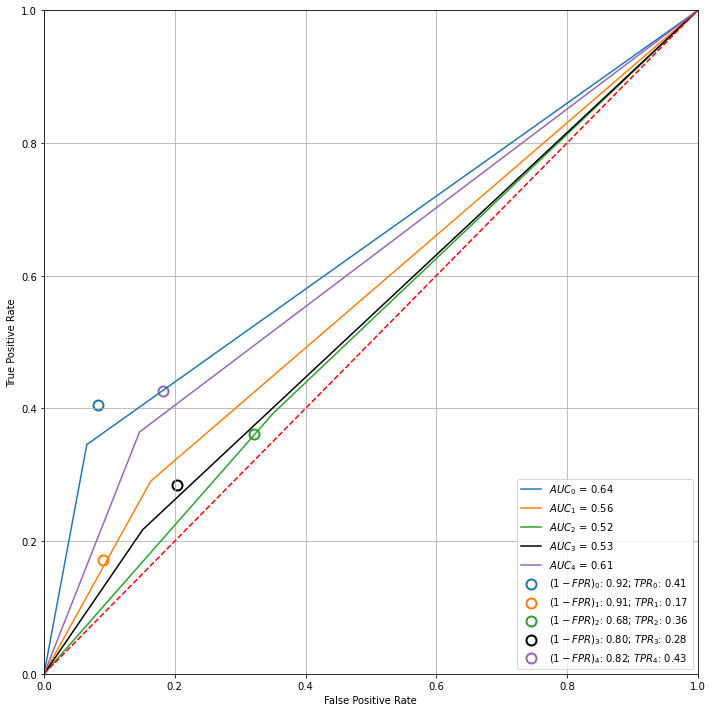

In [56]:
viz.plot_ROC(y_pred_classification, y_test_classification)

In [241]:
y_score.shape

(50, 3)

In [21]:
ohe_categories = (
    preprocessor.fit(X_train).named_transformers_["cat"]["onehot"].categories_
)
ohe_categories_concat = [
    f"{col}__{val}"
    for col, vals in zip(categorical_features, ohe_categories)
    for val in vals
]
all_features = numeric_features + bool_features + ohe_categories_concat
importance = clf.named_steps["model"].feature_importances_
feature_importance = (
    pd.DataFrame(importance, index=all_features)
    .rename(columns={0: "pct_importance"})
    .sort_values(by="pct_importance", ascending=False)
)
feature_importance[feature_importance.pct_importance>0.000001].head(50)

In [438]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [444]:
param_grid = [
    {
        "preprocesser__num_transform__imputer__strategy": ["mean", "median"],
        "classifier__C": [0.1, 1.0, 10.0, 100.0],
        "classifier": [LogisticRegression()]
    }
]

In [443]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'insulin_depend_duration',
                                                   'subjective_diabetic_control',
                                                   'years_diabetes',
                                                   'hist_glaucoma_self',
                                                   'hist_glaucoma_siblings',
                                                   'hist_glaucoma_parents']),
                                                 ('bool',
                                                  Pipeline(steps=[('label_binarizer',
                                                                   <__main__.MyLabelBi

In [439]:
grid_search = GridSearchCV(clf, param_grid, cv=10, verbose=1,n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


ValueError: Invalid parameter activation for estimator GridSearchCV(cv=3,
             estimator=MLPClassifier(alpha=1, learning_rate='adaptive',
                                     max_iter=3000),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']}). Check the list of available parameters with `estimator.get_params().keys()`.

In [437]:
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(alpha=1, max_iter=3000, learning_rate="adaptive")
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

/home/gerac/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


ValueError: could not convert string to float: 'caucasian'

<BarContainer object of 145 artists>

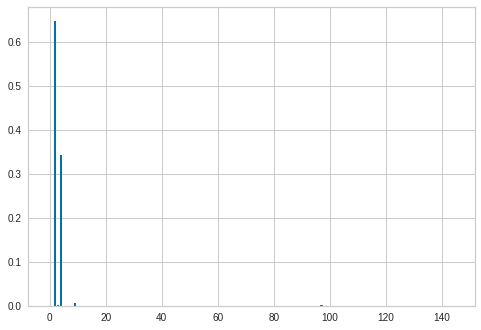

In [212]:
import matplotlib.pyplot as plt

plt.bar([x for x in range(len(importance))], importance)

In [426]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

ValueError: multi_class must be in ('ovo', 'ovr')

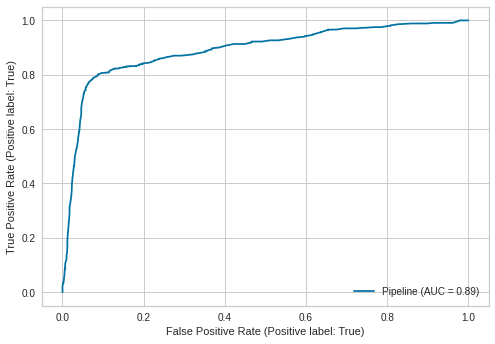

In [395]:
from sklearn import datasets, metrics, model_selection, svm

metrics.plot_roc_curve(clf, X_test, y_test) 

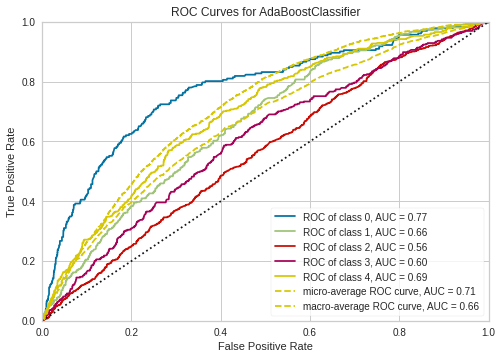

<AxesSubplot:title={'center':'ROC Curves for AdaBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [427]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(clf, classes=["0", "1", "2", "3", "4"])
#visualizer = ROCAUC(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and render the figure

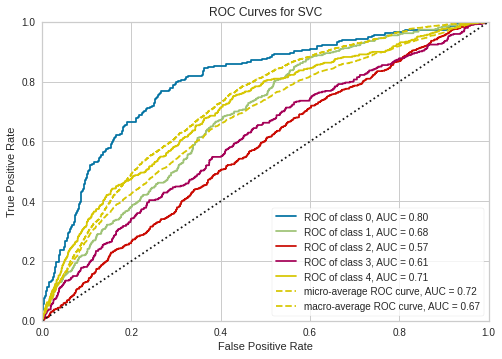

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [432]:
visualizer = ROCAUC(clf, classes=["0", "1", "2", "3", "4"])
#visualizer = ROCAUC(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and render the figure

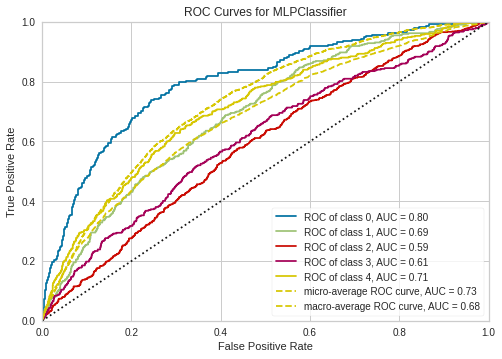

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [434]:
visualizer = ROCAUC(clf, classes=["0", "1", "2", "3", "4"])
#visualizer = ROCAUC(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and render the figure

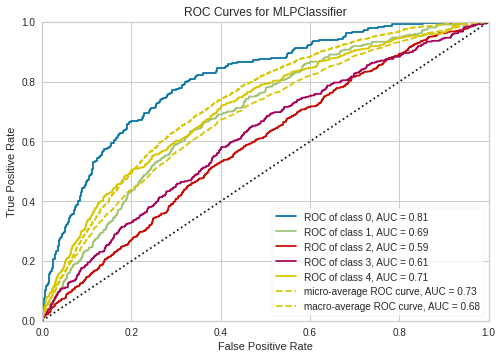

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [474]:
visualizer = ROCAUC(clf, classes=["0", "1", "2", "3", "4"])
#visualizer = ROCAUC(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and render the figure

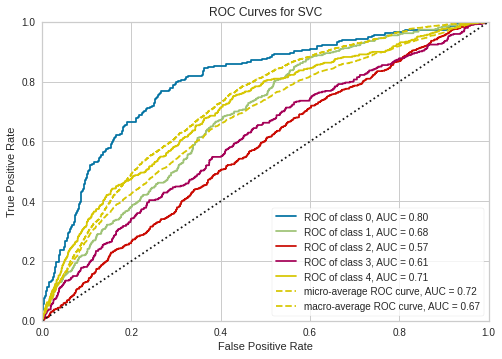

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [460]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(clf, classes=["0", "1", "2", "3", "4"])
#visualizer = ROCAUC(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and render the figure

In [461]:
y_pred = clf.predict(X_test)

In [463]:
pd.crosstab(y_test, y_pred, rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,0,1,2,3,4
Actual Species,,,,,
0,30,19,180,0,3
1,16,35,357,0,12
2,10,18,785,1,53
3,5,5,358,1,25
4,1,5,371,0,91


In [466]:
from sklearn.metrics import cohen_kappa_score

In [472]:
# SVC
cohen_kappa_score(y_test, y_pred, weights= 'quadratic')

0.2355905356643252

In [479]:
# SVC
cohen_kappa_score(y_test, y_pred, weights= 'quadratic')

0.2355905356643252

In [464]:
import seaborn as sns

<AxesSubplot:xlabel='Predicted values', ylabel='Actual values'>

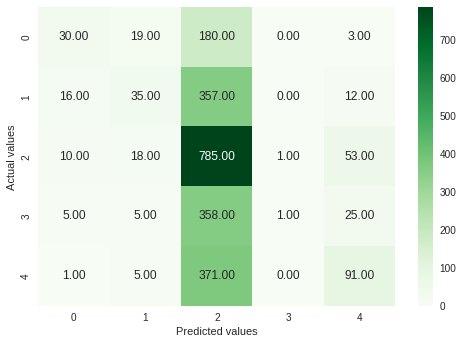

In [480]:
sns.heatmap(
    pd.crosstab(
        y_test, y_pred, rownames=["Actual values"], colnames=["Predicted values"]
    ), annot=True, fmt='.2f', cmap='Greens'
)

<AxesSubplot:xlabel='Predicted values', ylabel='Actual values'>

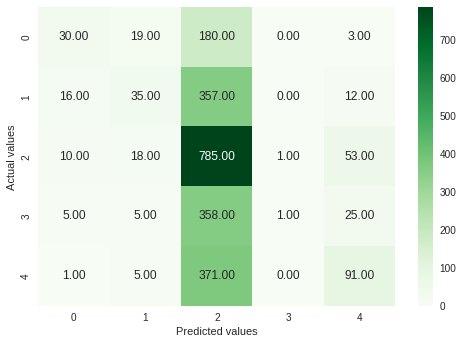

In [477]:
sns.heatmap(
    pd.crosstab(
        y_test, y_pred, rownames=["Actual values"], colnames=["Predicted values"]
    ), annot=True, fmt='.2f', cmap='Greens'
)

In [476]:
# MLP
cohen_kappa_score(y_test, y_pred, weights= 'quadratic')

0.2355905356643252

In [166]:
from sklearn.metrics import roc_auc_score

# Generate class membership probabilities
y_preb_probs = clf.predict_proba(X_test)

roc_auc_score(
y_test, y_preb_probs, average="weighted", multi_class="ovr"
)

0.6154849534252148